<a href="https://colab.research.google.com/github/JaxonOShea/Recommender-Projects/blob/main/Two_Tower_Recommender_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two Tower Recommender Study
In the music streaming industry, providing personalized recommendations is essential for enhancing user experience and engagement. Recommender systems play a crucial role by predicting what users might want to listen to based on their past behavior and preferences.

One effective approach is the Two-Tower model, also known as the Two-Tower Recommender. This collaborative filtering method matches users with songs or artists they might like by utilizing two separate neural networks (or towers). One tower processes user features, while the other processes item features.

This notebook explores the implementation of a Two-Tower model for music recommendations, focusing on the impact of listener information—such as age, gender, and nationality—on the model's accuracy.

---



**Table of Contents**

1. Data Wrangling and Preparation <br>
  1.1 Loading Data <br>
  1.2 Cleaning and Wrangling of Plays DF <br>
  1.3 Cleaning and Wrangling of Users DF <br>
  1.4 Preparing the Datasets <br>
2. Query Model <br>
  2.1 Baseline Model <br>
  2.2 Model with all embeddings <br>
3. Candidate Model <br>
  3.1 Model <br>
4. Combinded Models <br>
  4.1 Baseline Model <br>
  4.2 Model with Embeddings<br>
  4.3 Results <br>
5. Predictions <br>
6. Summary <br>
---

 0. Libraries<br>

All the necessary libraries and packages for completing this recommender are loaded here.

In [1]:
# install tensorflow recommenders package
!pip install -q tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 4.7 MB/s eta 0:00:00


In [2]:
# import required libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import tensorflow_recommenders as tfrs
from typing import Dict, Text
import matplotlib.pyplot as plt

In [3]:
# load google drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 - Data Wrangling and Preparation
This section covers the initial steps of loading, cleaning, and organising the data needed for the Two-Tower Recommender model. Key aspects include handling missing values, converting to Tensorflow datasets, and separating the data into test, train and validation sets.

1. Data Wrangling and Preparation <br>
  1.1 Loading Data <br>

The data for this project was sourced from [last.fm](https://last.fm)
 and downloaded from [this website](https://http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html)

In [4]:
# define project directory and show subfolders/files
dir = "/content/drive/MyDrive/Colab Notebooks/Recommenders/02-Two_Tower_Model"

#Import play data to dataframe and add column names
df_plays = pd.read_csv(os.path.join(dir, '01-Data', 'usersha1-artmbid-artname-plays.tsv'), sep='\t', names=['user_code', 'artist_code', 'artist_name', 'plays'])
df_plays.head()

,user_code,artist_code,artist_name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


In [5]:
#Import user profile data to dataframe and add column names
df_users = pd.read_csv(os.path.join(dir, '01-Data', 'usersha1-profile.tsv'), sep='\t', names=['user_code', 'gender', 'age', 'country', 'signup'])
df_users.head()

,user_code,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


  1.2 Cleaning and Wrangling of Plays DF <br>

Before using the data for the recommender system, it is essential to review and clean it. In this example, the data will be checked for its size, the number of unique entries, and the presence of any null values.

In [6]:
# basic exploritory analysis of dataframe
print('Number of lines in dataframe:', df_plays.shape[0])
print('Number of unique users in dataframe:', df_plays['user_code'].nunique())
print('Number of unique artists in dataframe by code:', df_plays['artist_code'].nunique())
print('Number of unique artists in dataframe by name:', df_plays['artist_name'].nunique())

# checking for null values
print('Null values per column:\n',df_plays.isna().sum())

Number of lines in dataframe: 17535655
Number of unique users in dataframe: 358868
Number of unique artists in dataframe by code: 160112
Number of unique artists in dataframe by name: 292363
Null values per column:
 user_code           0
artist_code    226137
artist_name       204
plays               0
dtype: int64


From the results, approximately 226,000 entries have incomplete artist information. For this tutorial only the artist_name will be used, so the entries with missing artist_code can be ignored and the one missing artist_name will be removed.

In [7]:
# remove null values from dataframe
df_plays = df_plays[df_plays['artist_name'].notna()]
df_plays.isna().sum()

user_code           0
artist_code    226135
artist_name         0
plays               0
dtype: int64

In [8]:
# remove column artist_code from dataframe because there are too many null values
df_plays = df_plays[['user_code', 'artist_name', 'plays']]


  1.3 Cleaning and Wrangling of Users DF <br>

In [9]:
# checking for null values in
print(df_users.isna().sum())

user_code        0
gender       32775
age          74900
country          0
signup           0
dtype: int64


There are only null values in the gender and age. This isn't an issue as both these feature will be treated as categorical data when creating the embeddings.

In [10]:
# to ensure the input data is compatible with TensorFlow, null value will be replaced and the data type is changed
df_users = df_users.fillna(0)
df_users[['age']] = df_users[['age']].astype('str')
df_users[['gender']] = df_users[['gender']].astype('str')
df_users.dtypes

user_code    object
gender       object
age          object
country      object
signup       object
dtype: object

The two dataframes need to be combined to one for the purpose of training, testing and validation. The dataframes will be join in the user codes.

In [11]:
df_train = pd.merge(df_plays, df_users, on='user_code')
df_train.head()

,user_code,artist_name,plays,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,f,22.0,Germany,"Feb 1, 2007"
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,f,22.0,Germany,"Feb 1, 2007"
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,f,22.0,Germany,"Feb 1, 2007"
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,f,22.0,Germany,"Feb 1, 2007"
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,f,22.0,Germany,"Feb 1, 2007"


In [12]:
# due to limited computing power, the model will be trained and tested using the first 100,000 records.
df_train_100k = df_train[:100000]
print('length of dataframe:', len(df_train_100k))

length of dataframe: 100000


1.4 Preparing the Datasets

Now that the dataframes are cleaned, it is needed to convert them to tensorflow datasets and prepare the additional datasets that are required to create the embeddings.

In [13]:
# convert dataframe to tensor dataset
train_100k_tf = tf.data.Dataset.from_tensor_slices(dict(df_train_100k))

In [14]:
# remap the dictionaries to ensure the keys are correct and consistamt
train = train_100k_tf.map(lambda x:{
    'user_code': x['user_code'],
    'artist_name': x['artist_name'],
    'gender': x['gender'],
    'age': x['age'],
    'country': x['country'],
    'signup': x['signup'],
    'plays': x['plays']
    })

Shuffle the data and create test, validation and test data sets

In [15]:
tf.random.set_seed(42)
shuffled = train_100k_tf.shuffle(100000, seed=42, reshuffle_each_iteration=False)

# split the data into train, validation and test
train_shuffled = shuffled.take(80000)
val_shuffled = shuffled.skip(80000).take(10000)
test_shuffled = shuffled.skip(90000).take(10000)

In [16]:
cached_train = train_shuffled.batch(1000).cache()
cached_val = val_shuffled.batch(1000).cache()
cached_test = test_shuffled.batch(1000).cache()

In [17]:
# create unique user and artist datasets
users = train_100k_tf.batch(1000).map(lambda x: x['user_code'])
artists = train_100k_tf.batch(1000).map(lambda x: x['artist_name'])
gender = train_100k_tf.batch(1000).map(lambda x: x['gender'])
age = train_100k_tf.batch(1000).map(lambda x: x['age'])
country = train_100k_tf.batch(1000).map(lambda x: x['country'])

unique_users = np.unique(np.concatenate(list(users)))
unique_artists = np.unique(np.concatenate(list(artists)))
unique_gender = np.unique(np.concatenate(list(gender)))
unique_age = np.unique(np.concatenate(list(age)))
unique_country = np.unique(np.concatenate(list(country)))




---



# 2 - Query Model (User Tower)
This section delves into the construction of the first neural network (the user tower) that processes user-specific features. This model captures the user profile by learning embeddings from user attributes such as age, gender, and nationality.


Below, five distinct user models have been developed and will be compared to evaluate the influence of features (embeddings) on model accuracy.

2.1 Baseline Model <br>



In [18]:
class UserModelBaseline(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 16

    # user embeddings
    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='user_code', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_users, mask_token=None),
        tf.keras.layers.Embedding(len(unique_users) + 1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenUser')
    ])

    # artist embeddings
    self.artist_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='artist_name', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_artists, mask_token=None),
        tf.keras.layers.Embedding(len(unique_artists) +1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenArtist')
        ])

  def call(self, inputs):
    user = inputs['user_code']
    artist = inputs['artist_name']

    user_embedding = self.user_embedding(user)
    artist_embedding = self.artist_embedding(artist)

    # Debugging help:
    #print("User embedding shape:", user_embedding.shape)
    #print("Artist embedding shape (UM):", artist_embedding.shape)

    return tf.concat([user_embedding, artist_embedding], axis=1)

2.5 Model with Embeddings <br>

In [19]:
class UserModelAll(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 16

    # user embeddings
    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='user_code', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_users, mask_token=None),
        tf.keras.layers.Embedding(len(unique_users) + 1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenUser')
    ])

    # artist embeddings
    self.artist_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='artist_name', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_artists, mask_token=None),
        tf.keras.layers.Embedding(len(unique_artists) +1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenArtist')
        ])

    # age embedding
    self.age_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='age', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_age, mask_token=None),
        tf.keras.layers.Embedding(len(unique_age) +1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenAge')
    ])

    # gender embedding
    self.gender_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='gender', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_gender, mask_token=None),
        tf.keras.layers.Embedding(len(unique_gender) +1,embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenGender')
    ])

    # country embedding
    self.country_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name='country', dtype=tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_country, mask_token=None),
        tf.keras.layers.Embedding(len(unique_country) +1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenCountry')
    ])

  def call(self, inputs):
    user = inputs['user_code']
    artist = inputs['artist_name']
    age = inputs['age']
    gender = inputs['gender']
    country = inputs['country']

    user_embedding = self.user_embedding(user)
    artist_embedding = self.artist_embedding(artist)
    age_embedding = self.age_embedding(age)
    gender_embedding = self.gender_embedding(gender)
    country_embedding = self.country_embedding(country)

    # Debugging help:
    #print("User embedding shape:", user_embedding.shape)
    #print("Artist embedding shape (UM):", artist_embedding.shape)
    #print("Age embedding shape:", age_embedding.shape)
    #print("Gender embedding shape:", gender_embedding.shape)
    #print("Country embedding shape:", country_embedding.shape)

    return tf.concat([user_embedding,artist_embedding, age_embedding, gender_embedding,country_embedding], axis=1)


---


# 3 - Candidate Model (Item Tower)
This section focuses on the second neural network, known as the item tower, which processes item-specific features such as song or artist characteristics. The candidate model learns embeddings based on these features to represent each item. For this tutorial, the item tower remains constant and only utilises the artist's name as a feature

In [20]:
class ArtistModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # artist embedding
    self.artist_embedding = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), name = 'artist_name', dtype = tf.string),
        tf.keras.layers.StringLookup(vocabulary=unique_artists, mask_token=None),
        tf.keras.layers.Embedding(len(unique_artists) + 1, embedding_dimension),
        tf.keras.layers.Flatten(name='FlattenArtistCan')
    ])

  def call(self, inputs):

    artist = inputs['artist_name']

    artist_embedding = self.artist_embedding(artist)

    return artist_embedding

---

# 4 - Combined Model
This part encompasses building the retrieval model that combines the outputs of the query and candidate models to generate recommendations. It discusses the method for calculating the similarity between user and item embeddings, enabling the retrieval of relevant recommendations based on this similarity

4.1 Baseline Model <br>

In [21]:
class RetrievalModelBase(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    self.query_model = tf.keras.Sequential([
        UserModelBaseline(),
        tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5)
    ])

    self.candidate_model = tf.keras.Sequential([
        ArtistModel(),
        tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5)
    ])

    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=train_100k_tf.batch(128).map(self.candidate_model)))


  def compute_loss(self, features, training=False):

    query_embeddings = self.query_model({
        'user_code': features['user_code'],
        'artist_name': features['artist_name'],
    })

    candidate_embeddings = self.candidate_model({
        'artist_name': features['artist_name'],
    })

    # Debugging help:
    #print("Shape of query_embeddings:", query_embeddings.shape)
    #print("Shape of candidate_embeddings:", candidate_embeddings.shape)

    return self.task(query_embeddings, candidate_embeddings)

Training of the model:

In [22]:
retrieval_model_base = RetrievalModelBase()
tensorboard_callback_base = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(dir, '03-Weights', 'logs-base'))
retrieval_model_base.compile(optimizer=tf.keras.optimizers.Adagrad(0.1), run_eagerly=True)

In [23]:
history_base = retrieval_model_base.fit(x=cached_train, validation_data=cached_val, epochs=10, batch_size=64, callbacks=[tensorboard_callback_base])

Epoch 1/10
80/80 [==============================] - 195s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.2034 - factorized_top_k/top_5_categorical_accuracy: 0.2035 - factorized_top_k/top_10_categorical_accuracy: 0.2092 - factorized_top_k/top_50_categorical_accuracy: 0.2925 - factorized_top_k/top_100_categorical_accuracy: 0.3477 - loss: 4068.0433 - regularization_loss: 26.1666 - total_loss: 4094.2099 - val_factorized_top_k/top_1_categorical_accuracy: 0.3301 - val_factorized_top_k/top_5_categorical_accuracy: 0.3306 - val_factorized_top_k/top_10_categorical_accuracy: 0.3589 - val_factorized_top_k/top_50_categorical_accuracy: 0.5005 - val_factorized_top_k/top_100_categorical_accuracy: 0.5610 - val_loss: 2795.7417 - val_regularization_loss: 35.6741 - val_total_loss: 2831.4158
Epoch 2/10
80/80 [==============================] - 194s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.3821 - factorized_top_k/top_5_categorical_accuracy: 0.3930 - factorized_top_k/top_10_categorica

4.2 Model with Embeddings <br>

In [24]:
class RetrievalModelAll(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    self.query_model = tf.keras.Sequential([
        UserModelAll(),
        tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5)
    ])

    self.candidate_model = tf.keras.Sequential([
        ArtistModel(),
        tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5)
    ])

    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=train_100k_tf.batch(128).map(self.candidate_model)))


  def compute_loss(self, features, training=False):

    query_embeddings = self.query_model({
        'user_code': features['user_code'],
        'artist_name': features['artist_name'],
        'age': features['age'],
        'gender': features['gender'],
        'country': features['country'],
    })

    candidate_embeddings = self.candidate_model({
        'artist_name': features['artist_name'],
    })

    # Debugging help:
    #print("Shape of query_embeddings:", query_embeddings.shape)
    #print("Shape of candidate_embeddings:", candidate_embeddings.shape)

    return self.task(query_embeddings, candidate_embeddings)

Training of the model:

In [25]:
retrieval_model_all = RetrievalModelAll()
tensorboard_callback_all = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(dir, '03-Weights', 'logs'))
retrieval_model_all.compile(optimizer=tf.keras.optimizers.Adagrad(0.1), run_eagerly=True)

In [26]:
history_all = retrieval_model_all.fit(x=cached_train, validation_data=cached_val, epochs=10, batch_size=64, callbacks=[tensorboard_callback_all])

Epoch 1/10
80/80 [==============================] - 194s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.1803 - factorized_top_k/top_5_categorical_accuracy: 0.1803 - factorized_top_k/top_10_categorical_accuracy: 0.1858 - factorized_top_k/top_50_categorical_accuracy: 0.2634 - factorized_top_k/top_100_categorical_accuracy: 0.3191 - loss: 4250.0809 - regularization_loss: 24.6170 - total_loss: 4274.6979 - val_factorized_top_k/top_1_categorical_accuracy: 0.3143 - val_factorized_top_k/top_5_categorical_accuracy: 0.3143 - val_factorized_top_k/top_10_categorical_accuracy: 0.3367 - val_factorized_top_k/top_50_categorical_accuracy: 0.4809 - val_factorized_top_k/top_100_categorical_accuracy: 0.5450 - val_loss: 2893.5068 - val_regularization_loss: 33.6943 - val_total_loss: 2927.2012
Epoch 2/10
80/80 [==============================] - 196s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.3541 - factorized_top_k/top_5_categorical_accuracy: 0.3620 - factorized_top_k/top_10_categorica

In [27]:
# Save model weights for prediction/serving phase
retrieval_model_all.save_weights(filepath= os.path.join(dir, '03-Weights', 'trained_n_personalized_model'), overwrite=True)

4.6 Results

Now the two models are trained we can compare the Training and Validation loss of the models.

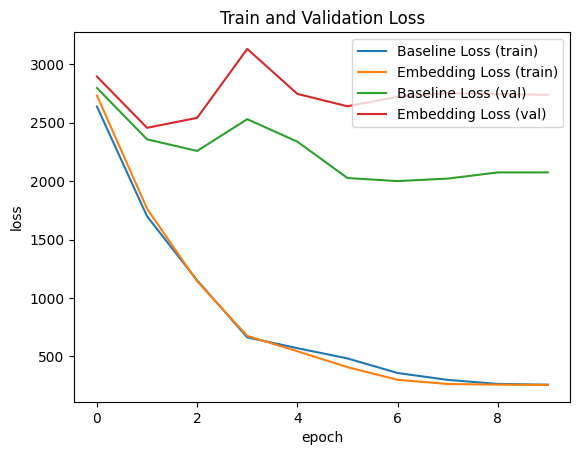

In [28]:
plt.plot(history_base.history['loss'])
plt.plot(history_all.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.plot(history_all.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Baseline Loss (train)', 'Embedding Loss (train)', 'Baseline Loss (val)', 'Embedding Loss (val)'], loc='upper right')
plt.show()

As can be seen from the graphs above, the model is performing poorly. While the train loss continues to decrease, the validation loss remains high. This is a strong indication that the model is overfitting the data despite the measures taken against it, i.e. the dropout layer and the L2 regularisation of the dense layer.

The overfitting appears to be confirmed by the fact that the embedding model performs worse than the baseline. It would be expected that in collaborative filtering, the additional information about the listener would help to improve accuracy. This trend can be triple checked by testing the models on the test datasets, data that the model hasn't encountered yet. This is not necessary, but has been done below for the sake of thoroughness.

Overfitting can be caused by a number of issues:
* Feature engineering and data quality: the features selected either have no predictive relationship and/or are poorly processed. This creates noise that the model learns rather than the underlying patterns.
* Model complexity: Neural networks are inherently high variance machines. Because of their ability to learn complex patterns, they tend to overfit. Architecturally, this can be addressed by simplifying the network and/or adding regularisation.

In addition to the above, cross validation can be added to the data pipeline to combat overfitting.


In [29]:
# testing the basline model against the test dataset
retrieval_model_base.evaluate(cached_test, return_dict=True)

10/10 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.5441 - factorized_top_k/top_5_categorical_accuracy: 0.6087 - factorized_top_k/top_10_categorical_accuracy: 0.6539 - factorized_top_k/top_50_categorical_accuracy: 0.7569 - factorized_top_k/top_100_categorical_accuracy: 0.7974 - loss: 1987.8187 - regularization_loss: 63.3449 - total_loss: 2051.1636


{'factorized_top_k/top_1_categorical_accuracy': 0.5440999865531921,
 'factorized_top_k/top_5_categorical_accuracy': 0.6086999773979187,
 'factorized_top_k/top_10_categorical_accuracy': 0.6539000272750854,
 'factorized_top_k/top_50_categorical_accuracy': 0.7569000124931335,
 'factorized_top_k/top_100_categorical_accuracy': 0.7973999977111816,
 'loss': 1961.7646484375,
 'regularization_loss': 63.34489440917969,
 'total_loss': 2025.1094970703125}

In [30]:
# testing the embeddings model against the test dataset
retrieval_model_all.evaluate(cached_test, return_dict=True)

10/10 [==============================] - 22s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.4623 - factorized_top_k/top_5_categorical_accuracy: 0.5018 - factorized_top_k/top_10_categorical_accuracy: 0.5534 - factorized_top_k/top_50_categorical_accuracy: 0.6962 - factorized_top_k/top_100_categorical_accuracy: 0.7515 - loss: 2556.2379 - regularization_loss: 60.7248 - total_loss: 2616.9628


{'factorized_top_k/top_1_categorical_accuracy': 0.46230000257492065,
 'factorized_top_k/top_5_categorical_accuracy': 0.501800000667572,
 'factorized_top_k/top_10_categorical_accuracy': 0.5533999800682068,
 'factorized_top_k/top_50_categorical_accuracy': 0.6962000131607056,
 'factorized_top_k/top_100_categorical_accuracy': 0.7515000104904175,
 'loss': 2598.1708984375,
 'regularization_loss': 60.72481918334961,
 'total_loss': 2658.895751953125}

---

# 5 - Predictions

The ML recommender model will be used to suggest new artists to listeners. This will be demonstrated here once the overfitting issue is resolved.

# 6 - Summary

  *to be completed once model in corrected*